In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install openai-clip

In [ ]:
import torch
import clip
from PIL import Image
import os

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

#Folder paths
CompVis_Folpath = "/content/drive/MyDrive/DSL_Final_Project/Images/CompVis"
FineTune_Folpath = "/content/drive/MyDrive/DSL_Final_Project/Images/fine_tuned"

CV_files = os.listdir(CompVis_Folpath)
FT_files = os.listdir(FineTune_Folpath)

index = CV_files[0].find('album')

CompVis_texts = [text[text.find('album'):text.find('.png')].replace("_", " ") for text in CV_files]
FineTune_texts = [text[text.find('album'):text.find('.png')].replace("_", " ") for text in FT_files]
print(CompVis_texts)
CV_text_inputs = clip.tokenize(CompVis_texts).to(device)
FT_text_inputs = clip.tokenize(FineTune_texts).to(device)

100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 49.7MiB/s]


['album cover for genre rap', 'album cover for genre rap for album titled Liberation from the year 2003', 'album cover for genre rap for album titled Hustle Manifesto from the year 2012', 'album cover for genre rap for album titled Genesis', 'album cover for genre rap from the year 1994', 'album cover for genre pop', 'album cover for genre pop for album titled Eternal Love Notes from the year 2002', 'album cover for genre pop for album titled Dreamland from the year 1997', 'album cover for genre pop for album titled Harmonic Dreams', 'album cover for genre pop from the year 1991', 'album cover for genre indie', 'album cover for genre indie for album titled Whispering Breeze from the year 2012', 'album cover for genre indie for album titled Celestial Echo from the year 2023', 'album cover for genre indie for album titled Sunlit', 'album cover for genre indie from the year 2007', 'album cover for genre heavy metal', 'album cover cover for genre heavy metal for album titled Eternal Shadow

In [ ]:
CompVis_image_paths = [os.path.join(CompVis_Folpath, file) for file in CV_files]
FineTune_image_paths = [os.path.join(FineTune_Folpath, file) for file in FT_files]

CompVis_images = [Image.open(path) for path in CompVis_image_paths]
FineTune_images = [Image.open(path) for path in FineTune_image_paths]

CV_inputs = torch.stack([preprocess(image).to(device) for image in CompVis_images])
FT_inputs = torch.stack([preprocess(image).to(device) for image in FineTune_images])

# Calculate features
with torch.no_grad():
    CV_feat = model.encode_image(CV_inputs)
    FT_feat = model.encode_image(FT_inputs)
    CV_text_features = model.encode_text(CV_text_inputs)
    FT_text_features = model.encode_text(FT_text_inputs)

# Calculate cosine similarities
CV_feat /= CV_feat.norm(dim=-1, keepdim=True)
CV_text_features /= CV_text_features.norm(dim=-1, keepdim=True)
CV_similarity = torch.matmul(CV_text_features, CV_feat.T)

FT_feat /= FT_feat.norm(dim=-1, keepdim=True)
FT_text_features /= FT_text_features.norm(dim=-1, keepdim= True)
FT_similarity = torch.matmul(FT_text_features, FT_feat.T)

# Convert similarity scores to probabilities
CV_probabilities = CV_similarity.softmax(dim=-1).cpu().numpy()
FT_probabilities = FT_similarity.softmax(dim=-1).cpu().numpy()

print("Comp Vis Similarity scores:\n", CV_similarity)
print("Comp Vis Probabilities:\n", CV_probabilities)
print("Fine Tuned Similarity scores:\n", FT_similarity)
print("Fine Tuned Probabilities:\n", FT_probabilities)

Comp Vis Similarity scores:
 tensor([[0.2124, 0.2424, 0.2064,  ..., 0.2346, 0.2246, 0.2232],
        [0.2063, 0.2848, 0.1843,  ..., 0.2419, 0.2060, 0.1961],
        [0.2161, 0.2014, 0.3007,  ..., 0.2147, 0.2093, 0.1831],
        ...,
        [0.1523, 0.1884, 0.2108,  ..., 0.3004, 0.2412, 0.2231],
        [0.1728, 0.1861, 0.1734,  ..., 0.2904, 0.3390, 0.2359],
        [0.1877, 0.2394, 0.2258,  ..., 0.2760, 0.2521, 0.2518]])
Comp Vis Probabilities:
 [[0.0155302  0.01600212 0.01543764 ... 0.01587884 0.01572063 0.01569917]
 [0.0155496  0.01682008 0.0152111  ... 0.0161135  0.01554518 0.01539139]
 [0.01593348 0.0157008  0.01734004 ... 0.0159119  0.01582522 0.01541645]
 ...
 [0.01475741 0.01530012 0.01564655 ... 0.01711304 0.01613026 0.01584079]
 [0.01511151 0.01531418 0.01512059 ... 0.01699813 0.01784444 0.01609667]
 [0.01482354 0.01561011 0.01539994 ... 0.01619219 0.01581089 0.0158049 ]]
Fine Tuned Similarity scores:
 tensor([[0.2478, 0.2350, 0.2277,  ..., 0.2216, 0.2169, 0.2234],
        [

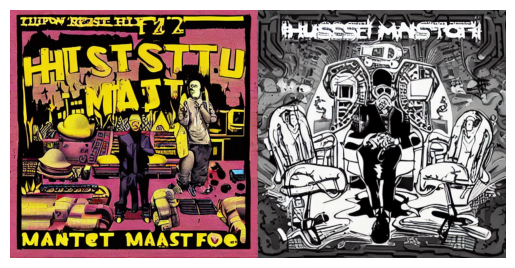

album cover for genre rap for album titled Hustle Manifesto from the year 2012


In [ ]:
import matplotlib.pyplot as plt

plt.imshow(CompVis_images[2])
plt.axis('off')  # Turn off axis numbers
plt.show()
print(CompVis_texts[2])

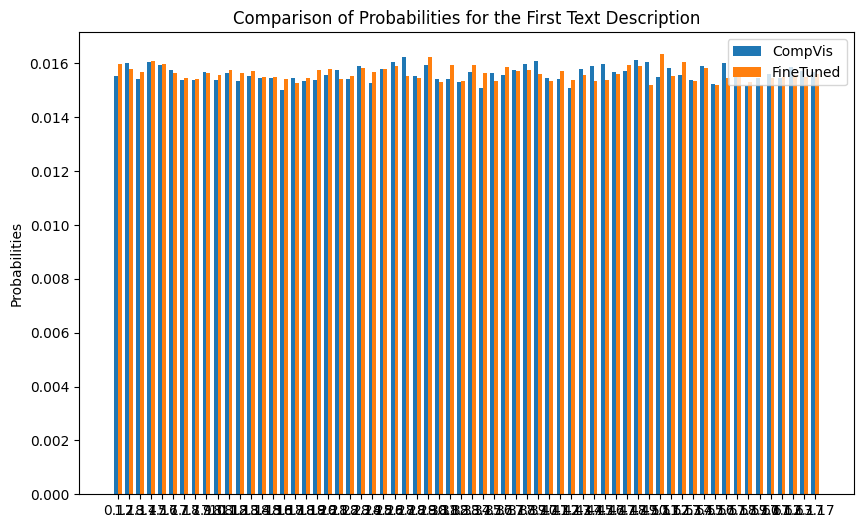

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming CV_probabilities and FT_probabilities are numpy arrays with shape (num_texts, num_images)
# For this example, we'll compare the probabilities of the first text description in both models

CV_probs = CV_probabilities[0]  # Probabilities of the first text for CompVis images
FT_probs = FT_probabilities[0]  # Probabilities of the first text for FineTuned images

# Number of images (assuming both models have the same number of images)
num_images = len(CV_probs)

# Create an index for each image
ind = np.arange(num_images)

# Bar width
width = 0.35

plt.figure(figsize=(10,6))

# Plotting
plt.bar(ind, CV_probs, width, label='CompVis')
plt.bar(ind + width, FT_probs, width, label='FineTuned')

# Adding labels and title
plt.ylabel('Probabilities')
plt.title('Comparison of Probabilities for the First Text Description')

plt.xticks(ind + width / 2)  # Replace with actual image labels if available
plt.legend(loc='best')

plt.show()


In [ ]:
# Average similarity scores
CV_avg_similarity = torch.mean(CV_similarity)
FT_avg_similarity = torch.mean(FT_similarity)

# Average probability scores
CV_avg_probability = np.mean(CV_probabilities)
FT_avg_probability = np.mean(FT_probabilities)

print("Average Similarity - CompVis:", CV_avg_similarity)
print("Average Similarity - FineTuned:", FT_avg_similarity)
print("Average Probability - CompVis:", CV_avg_probability)
print("Average Probability - FineTuned:", FT_avg_probability)

Average Similarity - CompVis: tensor(0.2154)
Average Similarity - FineTuned: tensor(0.2225)
Average Probability - CompVis: 0.015625
Average Probability - FineTuned: 0.015625


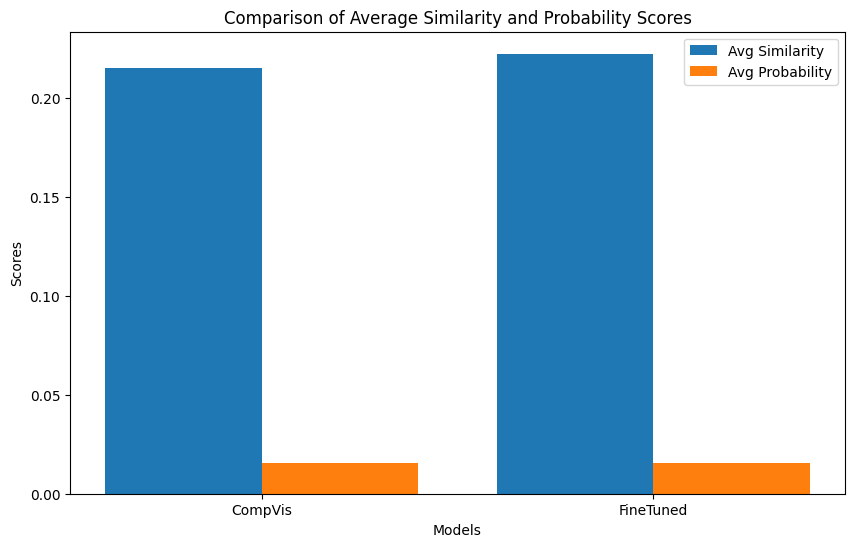

In [ ]:
labels = ['CompVis', 'FineTuned']
avg_similarities = [CV_avg_similarity, FT_avg_similarity]
avg_probabilities = [CV_avg_probability, FT_avg_probability]

x = np.arange(len(labels))

plt.figure(figsize=(10, 6))

plt.bar(x - 0.2, avg_similarities, 0.4, label='Avg Similarity')
plt.bar(x + 0.2, avg_probabilities, 0.4, label='Avg Probability')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Comparison of Average Similarity and Probability Scores')
plt.xticks(x, labels)
plt.legend()

plt.show()


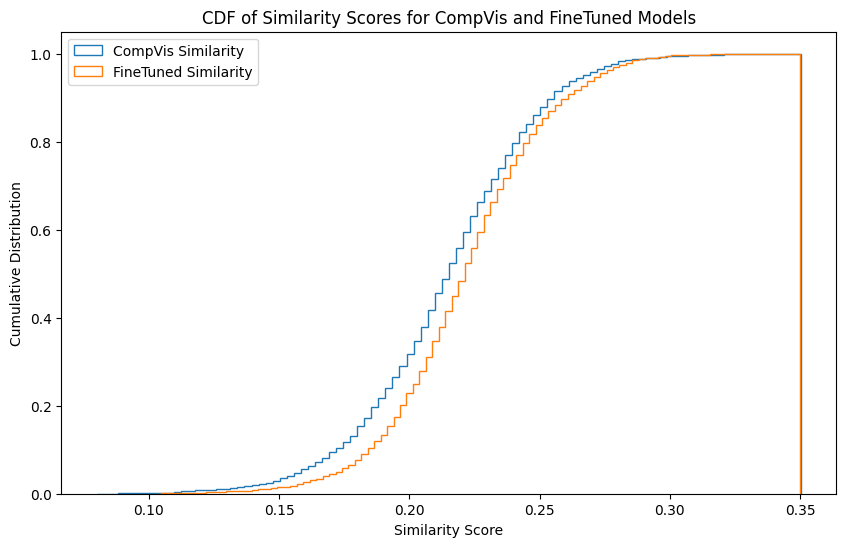

In [ ]:
plt.figure(figsize=(10, 6))

plt.hist(CV_similarity.flatten(), bins=100, density=True, histtype='step', cumulative=True, label='CompVis Similarity')
plt.hist(FT_similarity.flatten(), bins=100, density=True, histtype='step', cumulative=True, label='FineTuned Similarity')

plt.xlabel('Similarity Score')
plt.ylabel('Cumulative Distribution')
plt.title('CDF of Similarity Scores for CompVis and FineTuned Models')
plt.legend()

plt.show()

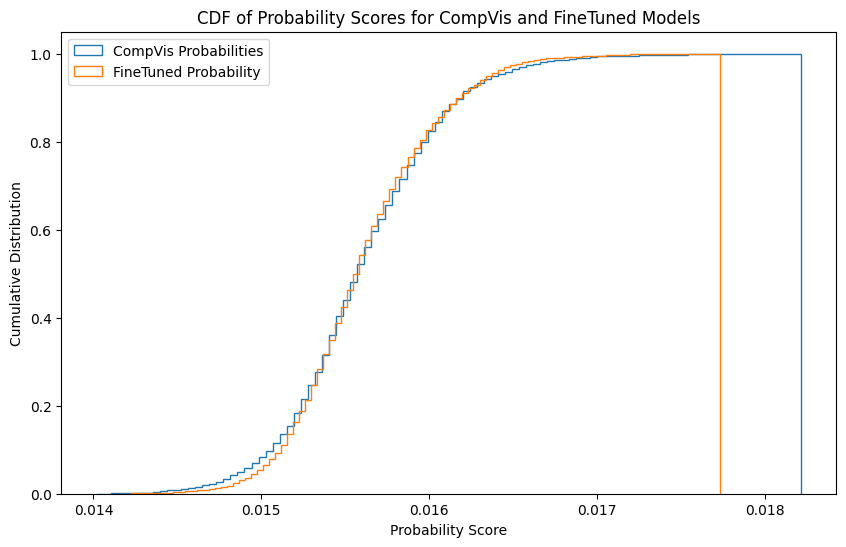

In [ ]:
plt.figure(figsize=(10, 6))

plt.hist(CV_probabilities.flatten(), bins=100, density=True, histtype='step', cumulative=True, label='CompVis Probabilities')
plt.hist(FT_probabilities.flatten(), bins=100, density=True, histtype='step', cumulative=True, label='FineTuned Probability')

plt.xlabel('Probability Score')
plt.ylabel('Cumulative Distribution')
plt.title('CDF of Probability Scores for CompVis and FineTuned Models')
plt.legend()

plt.show()

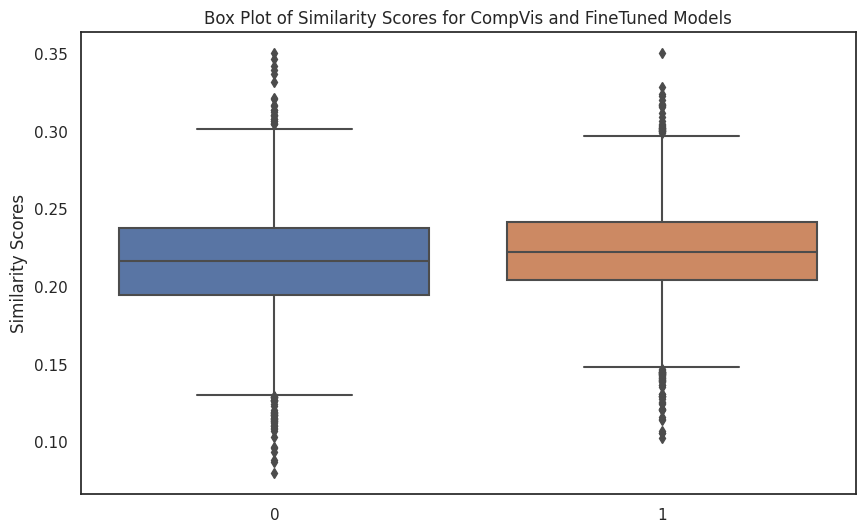

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


data_to_plot = [CV_similarity.flatten().numpy(), FT_similarity.flatten().numpy()]

sns.set(style="white")

plt.figure(figsize=(10, 6))

# Creating the box plot
box = sns.boxplot(data=data_to_plot)

# # Adding colors
# colors = ['#1f77b4', '#ff7f0e']
# for patch, color in zip(box['boxes'], colors):
#     patch.set_facecolor(color)

plt.ylabel('Similarity Scores')
plt.title('Box Plot of Similarity Scores for CompVis and FineTuned Models')

# for i, line in enumerate(data_to_plot, start=1):
#     y = line
#     x = np.random.normal(i, 0.04, size=len(y))  # Adding some jitter to the x-axis
#     plt.plot(x, y, 'r.', alpha=0.05)

plt.show()


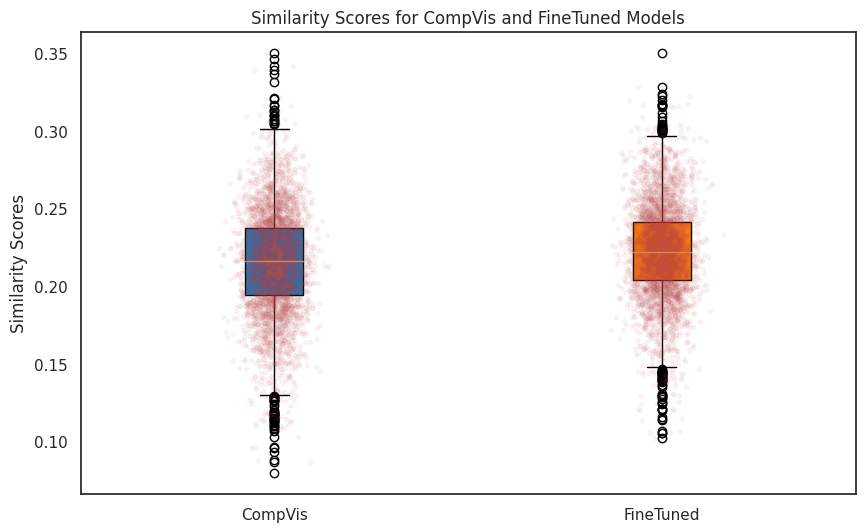

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


similarities = [CV_similarity.flatten().numpy(), FT_similarity.flatten().numpy()]

sns.set(style="white")

plt.figure(figsize=(10, 6))

# Creating the box plot
box = plt.boxplot(similarities, labels=['CompVis', 'FineTuned'], patch_artist=True)

# Adding colors
colors = ['#1f77b4', '#ff7f0e']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel('Similarity Scores')
plt.title('Similarity Scores for CompVis and FineTuned Models')

for i, line in enumerate(data_to_plot, start=1):
    y = line
    x = np.random.normal(i, 0.04, size=len(y))  # Adding some jitter to the x-axis
    plt.plot(x, y, 'r.', alpha=0.05)

plt.show()


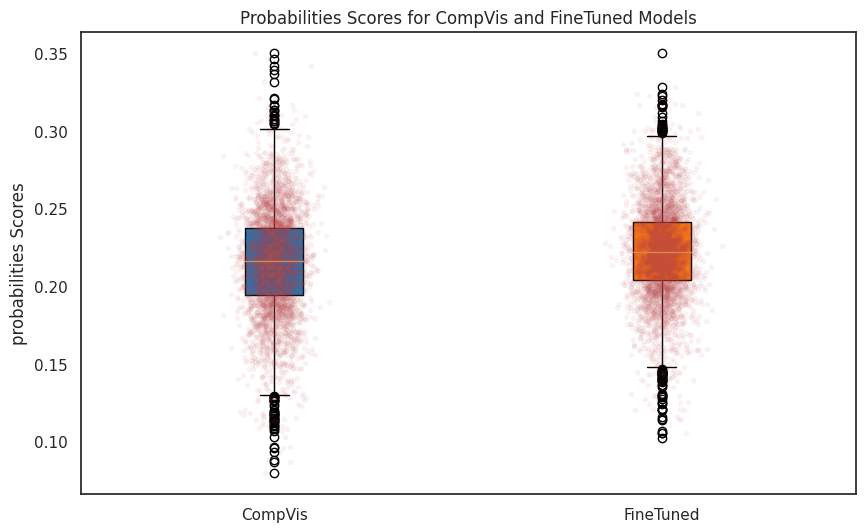

In [ ]:
probabilities = [CV_probabilities.flatten(), FT_probabilities.flatten()]

sns.set(style="white")

plt.figure(figsize=(10, 6))

# Creating the box plot
box = plt.boxplot(data_to_plot, labels=['CompVis', 'FineTuned'], patch_artist=True)

# Adding colors
colors = ['#1f77b4', '#ff7f0e']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel('probabilities Scores')
plt.title('Probabilities Scores for CompVis and FineTuned Models')

for i, line in enumerate(data_to_plot, start=1):
    y = line
    x = np.random.normal(i, 0.04, size=len(y))  # Adding some jitter to the x-axis
    plt.plot(x, y, 'r.', alpha=0.05)

plt.show()

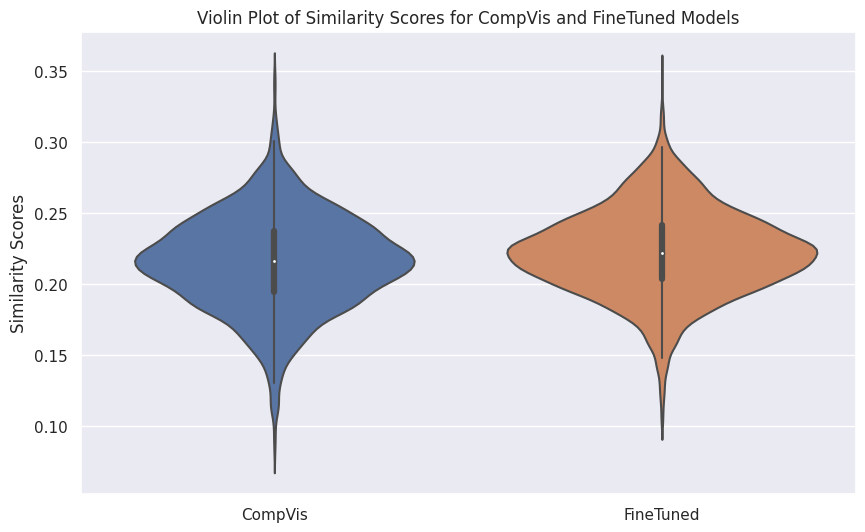

In [ ]:
data_to_plot = [CV_similarity.flatten().numpy(), FT_similarity.flatten().numpy()]

# Set the Seaborn style
sns.set(style="darkgrid")

# Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=data_to_plot)
plt.xticks([0, 1], ['CompVis', 'FineTuned'])
plt.ylabel('Similarity Scores')
plt.title('Violin Plot of Similarity Scores for CompVis and FineTuned Models')

plt.show()


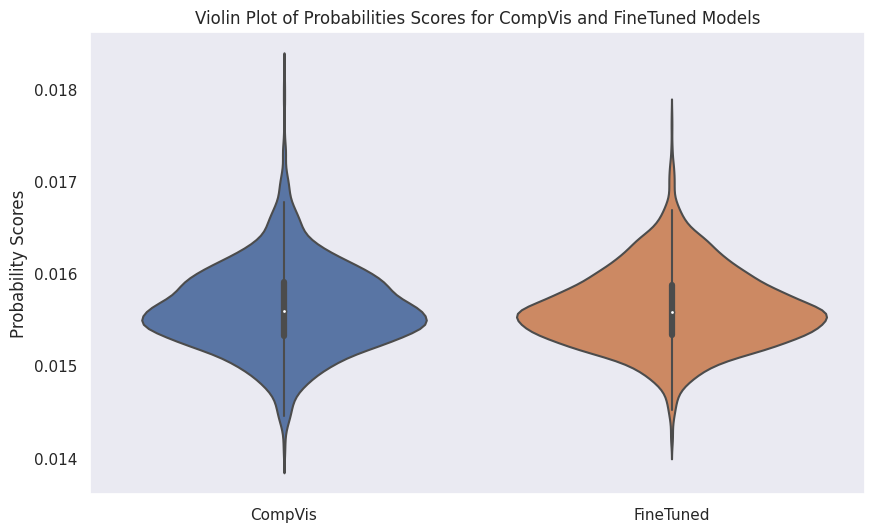

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Your custom data
data_to_plot = [CV_probabilities.flatten(), FT_probabilities.flatten()]

# Set the Seaborn style
sns.set(style="dark")

# Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=data_to_plot)
plt.xticks([0, 1], ['CompVis', 'FineTuned'])
plt.ylabel('Probability Scores')
plt.title('Violin Plot of Probabilities Scores for CompVis and FineTuned Models')

plt.show()
